# Autoencoder Convolucional - Redução de dimensionalidade

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import models, layers, datasets, utils, preprocessing

%matplotlib inline

## Obter os dados

In [2]:
# A base de dados já está dividida em dois conjuntos: treino e teste
# Como vai-se apenas fazer a redução da dimensionalidade não é necessária avariavel de saida. E o autoencoder é um algoritmo
# não supervisionado, por isso é utilizado normalmente quando não se tem acesso a esses dados. Mas tambem não se deveria dividir
# o dataset emtreino e teste.
# Coloca-se _ para que essa variavel não seja criada
(X_train, _), (X_test, _) = datasets.mnist.load_data()

In [3]:
# 60000 imagens para treino
len(X_train)

60000

In [4]:
# 10000 imagens para teste
len(X_test)

10000

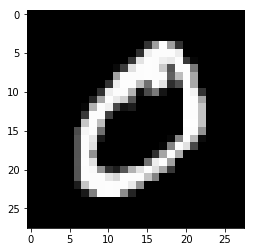

In [5]:
# Número zero a preto e branco
plt.imshow(X_train[1], cmap="gray")

In [6]:
# Matriz com os pixeis da imagem com o número zero.
# Matriz 28x28 (784 pixeis).
pixeis = X_train[1]
pixeis.shape

(28, 28)

# Pré-Processamento dos dados

In [7]:
# 60000 imagens para treino
X_train.shape[0]

60000

### Transformar os dados num vector em que o tensorflow consiga fazer a sua leitura.

In [8]:
# Para redes neurais convolucionais:
# 1º parametro: número de imagens
# 2º parametro: Altura da imagem (nº de pixeis da imagem na vertical).
# 3º parametro: Largura da imagem (nº de pixeis da imagem na horizontal).

# Nº de canais de RGB: Como a cor não tem influência neste caso pode-se utilizar a imagem a preto e branco(rgb=1). Quando se 
# utilizam as imagens a cores (rgb=3) o algoritmo fica mais lento porque aumenta a dimensionalidade dos dados. Uma imagem a 
# cores tem 3 canais(valores) dentro de cada pixel, porque o pixel é subdividio em vermelho(r), verde(g e azul(b)). Com rgb=1 
# tem-se menos dados para processar.

# A escala de cinzento possui apenas um canal. Quanto mais próximo de 255 mais claro é o cinzento e quanto mais próximo de 
# 0 mais escura é a cor.
# Nesta escala o Pixel com o valor 255 é o branco e pixel 0 é o preto. Ao redor do número tem-se apenas o valor 0, que indica o 
# preto(o fundo é preto).

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1) # (60000, 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [9]:
X_train.shape

(60000, 28, 28, 1)

### Conversão dos dados do tipo int8 para float32

In [10]:
# Como os dados vão ser convertidos para uma escala entre 0 e 1 tem-se de converter os dados de inteiro8 para float32 para que
# os valores obtidos depois da normalização não sejam inteiros e consequentemente quase todos 0(por não haver números decimais).

X_test[0,1,1]
#type(X_test[0,1]) # Para redes neurais antificiais

array([0], dtype=uint8)

In [11]:
# Conversão dos dados em float 32
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

In [12]:
X_test[0,1,1]

array([0.], dtype=float32)

### Normalização dos pixeis

In [13]:
# passar os pixeis para uma escala de 0 a 1 para que o precessamento dos dados seja mais rapido
# Isto pode ser feito através da tecnica min max normalization. Como cada pixel ocupa 1 byte e o byte consegue guardar 256
# resultados possiveis(ou seja varia entre 0 e 255). 
# A normalização pode ser feita dividindo o pixel por 255 (tambem se podia utilizar o skit-learn).

# Pode-se ver que o valor máximo de um pixel é de 255
X_test[0].max()

255.0

In [14]:
X_test[0].min()

0.0

In [15]:
# Normalização do conjunto de teste e treino
X_train = X_train/255
X_test = X_test/255

In [16]:
X_test[0].max()

1.0

## Modelo Convolutional Autoencoder

In [24]:
# factor de compactação = 784/32 = 24.5.Vai-se compactar a imagem 24.5 vezes em relação à original.

# sequential - uma cada apos a outra
# dense - camadas fully conected, cada neuronio esta conectado a todos os neuronios da camada seguinte
#------------------------------------------------------------------------------------------------------------------------------

# Camada de convolução (conv2D porque é uma imagem):

# Operador de convolução: multiplicação da imagem(matriz de pixeis 28x28) por um detector de caracteristicas, feature detection
# ou filtro ou kernel(matriz normalmente 3x3 para imagens pequenas) que vai originar um mapa de caracteristicas.
# Este mapa tem como objectivo filtrar(detectar) as caracteristicas mais importantes da imagem. 

# Detectores de caracteristicas(filters):16, Utilizam-se 16 matrizes de detectores de caraceristicas que vão originar 16 mapas 
# de caracteristicas. Estes detectores de caracteristicas são originados variando os números da matriz até se obter aquele que 
# apresenta o melhor resultado. O recomendado é utilizar 64 kernels e seus multiplos(128, 256, 512, 1024, etc).

# Kernel_size: (3,3) matriz detectora de caracteristicas do tamanho 3x3 

# strider: (1,1) Os valores do mapa de caracteristicas são obtidos com a subdivisão da matriz da imagem a fazer-se movendo um 
# pixel para a direita e um pixel para baixo. Ao se escolher (2,2) a a subdivisão da matriz da imagem faz-se movendo dois 
# pixeis para a direita e dois pixeis para baixo.

# input_shape: dimensões da imagem e número de canais(1 para imagens sem cor e 3 para imagens com cor)

# função de activação: Aplica a função relu(transforma valores negativos em zero e mantem os restantes iguais) ao mapa de 
# caracteristicas. Isto permite detectar melhor os padrões(Transforma os pontos mais escuros(com valores negativos) em pontos 
# mais claros e mais parecidos com os restantes pontos).

# padding: forma que a imagem é passada, ao se escolher "same" está-se a dizer que a imagem é passada da mesma forma:
# (altura, largura, nº de canais).

#---------------------------------------------------------------------------------------------------------------------------

# Camada de Pooling
# O mapa de caracteristicas(neste caso 5x5) é percorrido por uma matriz(neste caso 2x2) para encontrar os valores maiores
#(caracteristicas mais importantes) e formar um nova matriz com esses valores(Poolin matrix).  
# Os valores da matriz de pooling são obtidos com a subdivisão do mapa de caracteristicas a fazer-se movendo uma coluna para a
# direita e uma coluna para baixo.
# Como neste caso tem-se 16 mapas de caracteristicas tem-se igual número de matrizes de pooling.

# Utiliza-se o Max Pooling para se obter o maior valor e assim realçar as caracteristicas principais da imagem. (tambem se podia
# utilizar a média ou o minimo valor). Utilizada para reduzir a dimensionalidade

# Utiliza-se o Up Sampling utiliza-se para aumentar a dimensionalidade. Faz o inverso do Max Pooling. Como se tivesse o 
# resultado do Max Pooling e retorna-se o valor original.

# pool_size: (2,2) tamanho da matriz utilizada para seleccionar as carateristicas do mapa de caracteristicas. Vai originar uma
# matriz pooling.

#---------------------------------------------------------------------------------------------------------------------------
# Camada de Flattening

# Transformar a matriz de pooling num vector que irá ser utilizado na camada de entrada da rede neural densa.
# Os valores dos neuronios da camada de entrada da rede neural serão os valores desse vector.
#---------------------------------------------------------------------------------------------------------------------------

# 1ª camada oculta
# número de neuronios para primeira modelação:
# (28x28)=784 multiplicada pelo kernel(3x3) origina uma matriz de caracteristicas (26,26) e originar uma matriz de pooling 
# (13x13) e o respectivo array com 169 valores. Ou seja irá-se ter em média 169 valores de entrada.
# ((169+10)/2=90). Optou-se por colocar 128 neuronios.

#--------------------------------------------------------------------------------------------------------------------------

# Camada de Saida
# filters: 1. Só se pretende receber 1 imagem(1 filtro,).
# Função de activação: sigmoid para retornar um valor entre 0 e 1(pixeis entre 0 e 1).

#---------------------------------------------------------------------------------------------------------------------------

# Convolution autoencoder
# Predende-se reduzir a dimensionalidade de 28x28x1. 
# Na codificação(encode):
# Camada de entrada: 28x28x1 (1 porque é uma figura)
# Camada de convolução(e pooling): 26x26x16 (matriz de pooling obtida por 16 detectores de caracteristicas).
# Camada de convolução(e pooling): 13x13x8
# Camada de convolução(e pooling): 4x4x8
# Camada de flatter: 128(4x4x8)  A camada com a redução da dimensionalidade pretendida.
# Na descodificação(decode):
# Camada de convolução(e pooling): 4x4x8
# Camada de convolução(e pooling): 8x8x8
# Camada de convolução(e pooling): 14x14x16
# Camada de saida: 28x28x1. Dimensão original(da camada de entrada).

model = models.Sequential()
# encode
model.add(layers.Conv2D(16, (3,3), input_shape=(28, 28, 1), activation="relu")) # 1º Camada convolução e definição da camada de entrada. 
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(8, (3,3), activation="relu", padding="same")) # 2º Camada convolução. 
model.add(layers.MaxPool2D(pool_size=(2,2), padding="same"))

model.add(layers.Conv2D(8, (3,3), activation="relu", padding="same", strides=(2,2))) # 3º Camada convolução. 


model.add(layers.Flatten()) # Vector com 128 neurónios. Imagem codificcada(Camada encode).
model.add(layers.Reshape((4,4,8))) # Transformação do vector encode em matriz(Camada encode em matriz).

# decode
model.add(layers.Conv2D(8, (3,3),activation="relu", padding="same"))
model.add(layers.UpSampling2D(size=(2,2)))

model.add(layers.Conv2D(8, (3,3),activation="relu", padding="same"))
model.add(layers.UpSampling2D(size=(2,2)))

model.add(layers.Conv2D(16, (3,3),activation="relu")) # Não se coloca o padding nesta camada
model.add(layers.UpSampling2D(size=(2,2)))

model.add(layers.Conv2D(filters=1, kernel_size=(3,3), activation="sigmoid", padding="same" )) # Imagem descodificada. 

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 13, 8)         1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 8)          

## Compilação e Ajuste do modelo autoencoder

In [28]:
# Optimizer: adam é uma optimização da descida do gradiente estócastico (usado para encontrar os melhores valores dos pesos).
# É o que melhor se adapta à maioria dos casos.

# loss = função de perda binary_crossentropy é a mais utilizada para classificação binária. Mede o quão afastada está a previsão
# do seu valor real(0 ou 1) para cada classe e faz a média desses erros(desvios) para obter o custo(loss). Como utiliza o
# logaritmo tem uma penalização maior quando existe uma classificação errada.

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])

In [30]:
# epochs: Quantas vezes o algoritmo percorre o conjunto de dados de treino totalmente e escolhe-se um detector de 
# carateristicas melhor. 

# 1ª epoca- calcula o erro para os primeiros 32 dados e actualiza todos os pesos. Calcula o erro para os 32 dados seguintes e 
# actualiza todos os pesos. E assim sucessivamente. Actualiza-se o detector de caracteristica no fim desta época.
# 2ª epoca- calcula o erro para os primeiros 32 dados(com os pesos da 1ª epoca) e actualiza todos os pesos. Calcula o o erro 
# para os 32 dados seguintes(com os pesos da 1ª epoca) e actualiza-se os pesos. E assim sucessivamente. Actualiza-se o detector
# de caracteristica no fim desta época.

# Validation data: Avaliação do modelo utilizando a base de dados de teste (val_accuracy).

# Em vez do y_train utiliza-se o X_train em seu lugar. 
# Está-se a fazer a codificação da camada de entrada no nº de neurónios da camada oculta.
# De seguida faz-se a descodificação da camada oculta na camada de saida.
# De seguida compara-se a camada de saida com a camada de entrada(e não com o y_train).
# Calcula-se o erro e ajustam-se os pesos utilizando a tecnica back-propagation.
# Repetem-se os passos anteriores para o número de épocas definido.

# Ajustar os dados de entrada de treino aos dados de saida de treino para treinar o modelo
model.fit(X_train, X_train, batch_size=256, epochs=10, validation_data=(X_test,X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.1322 - binary_accuracy: 0.8049 - val_loss: 0.1254 - val_binary_accuracy: 0.8059
Epoch 2/10
60000/60000 [==============================] - 111s 2ms/sample - loss: 0.1229 - binary_accuracy: 0.8072 - val_loss: 0.1185 - val_binary_accuracy: 0.8068
Epoch 3/10
60000/60000 [==============================] - 107s 2ms/sample - loss: 0.1169 - binary_accuracy: 0.8086 - val_loss: 0.1133 - val_binary_accuracy: 0.8082
Epoch 4/10
60000/60000 [==============================] - 115s 2ms/sample - loss: 0.1126 - binary_accuracy: 0.8096 - val_loss: 0.1103 - val_binary_accuracy: 0.8097
Epoch 5/10
60000/60000 [==============================] - 117s 2ms/sample - loss: 0.1093 - binary_accuracy: 0.8102 - val_loss: 0.1069 - val_binary_accuracy: 0.8092
Epoch 6/10
60000/60000 [==============================] - 115s 2ms/sample - loss: 0.1067 - binary_accuracy: 0.8107 - val_loss: 0.1

## Modelo Autoencoder para redução da dimensionalidade

In [36]:
# Com o modelo de autoencoder model fez-se a codificação e descodificação. Ou seja reduziu-se a dimensionalidade das imagens e
# depois voltou a transformar-se as imagens na dimensão original.
# Com o modelo encoder apenas se faz a codificação. Ou seja apenas se reduz a dimensionalidade das imagens.

# Modelo para fazer a redução de dimensionalidade.
# O modelo encoder recebe o original size e transforma no encoded_size.

# Model utiliza-se quando se quer criar manualmente a rede neural.
# Model(input=camada de entrada, outputs=camada de saida).

# Na camada de saida tem de se ver o nome no summary do modelo ou então escrever de novo a camada.

encoder = models.Model(inputs = model.input, outputs=model.get_layer("flatten_2").output )

In [37]:
# Transforma de 28x28x1(784) dimensões para 128 dimensões.
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10_input (InputLayer) [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 13, 8)         1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0     

In [38]:
# Imagens de teste codificadas(com redução de dimensionalidade de 784 para 32).
X_test_codificado = encoder.predict(X_test)
X_test_codificado[0].shape

(128,)

In [39]:
# Imagens de teste descodificadas(com a dimensionalidade original de 784).
X_test_descodificado = model.predict(X_test)
X_test_descodificado[0].shape

(28, 28, 1)

## Visualização das imagens

In [40]:
# Escolher um numero_imagens aleatorias do conjunto de teste.
# X_test.shape[0]: número de total de imagens no conjunto de teste.
# size: número de imagens que se quer escolher aleatoriamente.
numero_imagens = 10
imagens_teste = np.random.randint(X_test.shape[0], size=numero_imagens)

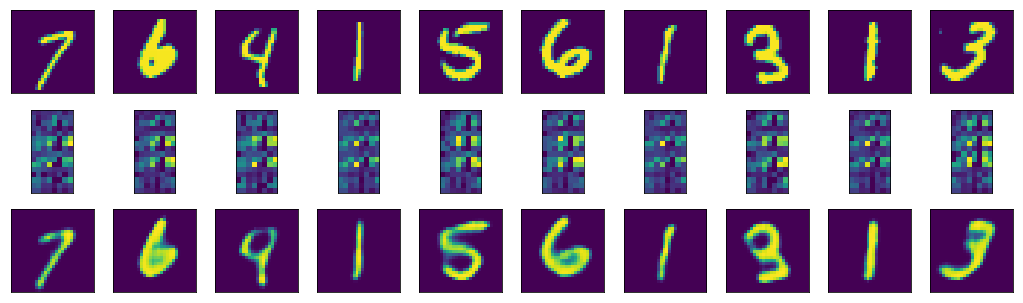

In [41]:
plt.figure(figsize=(18,18))

for i, indice_imagens in enumerate(imagens_teste):
    #print(i)
    #print(indice_imagens)
    
     # imagem original
    eixo = plt.subplot(10,10,i + 1)
    plt.imshow(X_test[indice_imagens].reshape(28,28)) #(28,28) tamanho da imagem original
    plt.xticks(())
    plt.yticks(())
    
    # imagem codificada
    eixo = plt.subplot(10,10,i + 1 + numero_imagens)
    plt.imshow(X_test_codificado[indice_imagens].reshape(16,8)) #(16,8)=128. Pode ser um dos tamanhos escolhidos para a imagem codificada
    plt.xticks(())
    plt.yticks(())
    
     # imagem reconstruída(codificada e depois descodificada)
    eixo = plt.subplot(10,10,i + 1 + numero_imagens * 2)
    plt.imshow(X_test_descodificado[indice_imagens].reshape(28,28)) #(28,28) tamanho da imagem original. Aumentando o
    # número de epocas as imagens reconstruidas vão aproximar-se das imagens originais.
    plt.xticks(())
    plt.yticks(())
    